# Test the HALO Downstreaming Pipelines

## Load the library

In [1]:
from typing import Dict, Iterable, Optional
import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import pandas as pd
from complementary_models import torch_infer_nonsta_dir
import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "/mnt/data0/halo/multivelo_BM/ATAC/multivelo_bonemarrow.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :15539
fine tune is False
gate decoder initialization n_input 10, n_output 175185,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


## Load pretrained model

In [3]:
model = model.load("model_multivelo_fig5_causal_01_softmax", adata_mvi)

INFO     File model_multivelo_fig5_causal_01_softmax/model.pt already downloaded             
n_genes :15539
fine tune is False
gate decoder initialization n_input 10, n_output 175185,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()


In [6]:
from complementary_models import torch_infer_nonsta_dir


latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score3 = []
score4=[]

cells = latent_expr.shape[0]
locals = 1500
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:,:], latent_expr_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:,:], latent_atac_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:(i+1)*locals,:], latent_expr_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:(i+1)*locals,:], latent_atac_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())



score3 = np.mean(np.array(score3))
score4 = np.mean(np.array(score4))

print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

/tmp/ipykernel_27675/3874022871.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  times = torch.tensor(times).to('cuda')


score3 0.06985152506460775 and score4 0.08519009754127453


-0.015338572476666784

In [7]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
# times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score1 = []
score2=[]

cells = latent_expr.shape[0]
locals = 1000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:,:], latent_expr_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:,:], latent_atac_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:(i+1)*locals,:], latent_expr_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:(i+1)*locals,:], latent_atac_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())


score1 = np.mean(np.array(score1))
score2 = np.mean(np.array(score2))

print("score1 {} and score2 {}".format(score1, score2))

score1 0.10319586622379515 and score2 0.10210508578064928


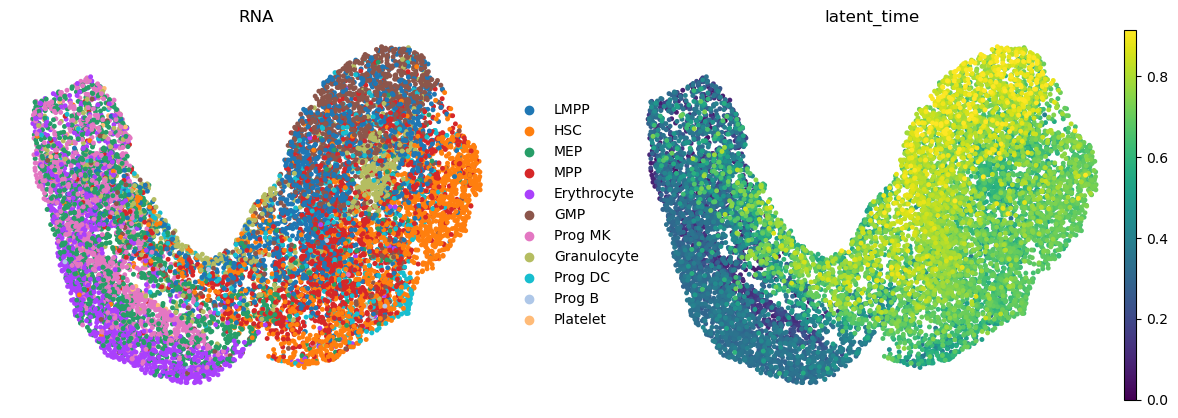

In [9]:
# adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color=['leiden', "latent_time"], s=50, frameon=False, ncols=2, vmax='p99', title="RNA")

plt.show()

In [4]:
### store the latent representations, latent denoms and library size of the autoencoder models
atac_denoms, rna_denoms = model.get_atac_expr_denoms()

In [10]:
from complementary_models import split_rna,split_atac
rna_data = split_rna(adata_mvi=adata_mvi)
atac_data = split_atac(adata_mvi)

In [14]:
rna_data.obs["softmax_denom"] = rna_denoms
atac_data.obs["softmax_denom"] = atac_denoms

## Get the coupled and decoupled Genes

### get the loading matrix

In [11]:
rnaloading = model.get_rna_loading()
rnaloading = rnaloading.T

[Text(0.5, 14.722222222222216, 'genes')]

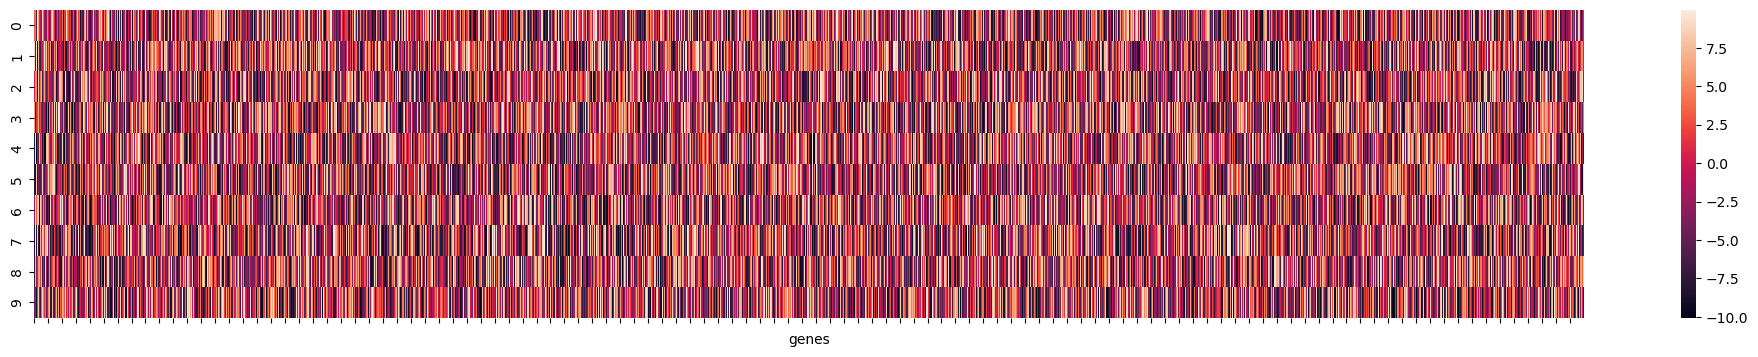

In [12]:
plt.figure(figsize=(25,4))
hm = sns.heatmap(rnaloading)
hm.set(xticklabels=[]) 
hm.set(xlabel="genes")

In [10]:
## get RNA data
from complementary_models import split_rna
rna_data = split_rna(adata_mvi=adata_mvi)


### get the highly variable genes

In [13]:
sc.pp.filter_genes(rna_data, min_cells=15)
rna_data.raw = rna_data
## normlaize the read depths of each cell, then logarithmize the data:
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)
# Calculate highly variable genes, but with a less stringent dispersion threshold. This set of genes will be our “exogenous” genes:
sc.pp.highly_variable_genes(rna_data, min_disp = 0.2, n_top_genes=None)
rna_data.var['exog'] = rna_data.var.highly_variable.copy()
# Finally, calculate the “endogenous” geneset by intersecting the exogenous set with genes with a higher dispersion threshold:
rna_data.var['endog'] = rna_data.var.exog & (rna_data.var.dispersions_norm > 0.7)
# Restore the raw counts to the counts layer.
rna_data.layers['counts'] = rna_data.raw.to_adata().X.copy()


In [12]:
## add the latent features of model
rna_data.obsm["X_topic_compositions"] = latent_expr

### get the decoupled score and couple scores from the loading matrix

In [14]:
couplescore, decouplescore = model.get_rna_decoupled_score(rnaloading, rnadata=rna_data)
rna_data.var["decouple_score"] = decouplescore
rna_data.var["couple_socre"] = couplescore
rna_data.var

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
AL627309.5,ENSG00000241860,Gene Expression,Gene Expression,256,False,0.021984,0.174730,-0.764677,False,False,0.220334,3.110317
LINC01409,ENSG00000237491,Gene Expression,Gene Expression,1052,False,0.094722,0.288982,-0.075881,False,False,1.976810,3.071110
LINC01128,ENSG00000228794,Gene Expression,Gene Expression,1054,False,0.095151,0.266282,-0.212734,False,False,1.573727,1.794742
LINC00115,ENSG00000225880,Gene Expression,Gene Expression,191,False,0.016869,0.223050,-0.473364,False,False,0.468066,0.159635
SAMD11,ENSG00000187634,Gene Expression,Gene Expression,123,False,0.011040,0.243950,-0.347365,False,False,2.192863,8.146992
...,...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,Gene Expression,136,False,0.012618,0.272546,-0.174966,False,False,1.844823,0.110405
AL592183.1,ENSG00000273748,Gene Expression,Gene Expression,2608,True,0.255719,0.353196,0.311251,True,False,0.710980,0.144477
AC240274.1,ENSG00000271254,Gene Expression,Gene Expression,226,False,0.021037,0.329299,0.167182,False,False,0.022495,0.899146
AC004556.3,ENSG00000276345,Gene Expression,Gene Expression,1609,False,0.135885,0.184492,-0.705820,False,False,0.088362,1.688544


In [20]:
rna_data.var.sort_values("decouple_score", ascending=False).head(30)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
ZNF695,ENSG00000197472,Gene Expression,Gene Expression,966,False,0.080404,0.152288,-0.899971,False,False,8.963240,1.286974
AL353135.2,ENSG00000288009,Gene Expression,Gene Expression,192,False,0.016506,0.218749,-0.499293,False,False,8.829124,4.647244
VPS16,ENSG00000215305,Gene Expression,Gene Expression,2165,False,0.190871,0.205487,-0.579247,False,False,8.760214,4.615226
AC106818.2,ENSG00000287180,Gene Expression,Gene Expression,1192,True,0.118866,0.483578,1.097286,True,True,8.503308,0.854788
ZNF775,ENSG00000196456,Gene Expression,Gene Expression,939,False,0.083832,0.258414,-0.260165,False,False,8.471423,0.413389
FMO4,ENSG00000076258,Gene Expression,Gene Expression,795,False,0.074337,0.304993,0.020645,False,False,8.471169,0.658635
VPS37B,ENSG00000139722,Gene Expression,Gene Expression,3849,False,0.364970,0.301830,-0.115116,False,False,8.407351,1.331715
MPP1,ENSG00000130830,Gene Expression,Gene Expression,6288,False,0.663512,0.387107,-0.029450,False,False,8.361061,3.844361
DIRAS1,ENSG00000176490,Gene Expression,Gene Expression,360,False,0.033162,0.255442,-0.278081,False,False,8.358118,0.555588
PPP1R12A-AS1,ENSG00000257557,Gene Expression,Gene Expression,359,False,0.031593,0.255492,-0.277782,False,False,8.237878,0.676298


In [16]:
## save the data
rna_data.write_h5ad("data/datasets/multivelo_rna_interim.h5ad")

In [17]:
## split the atac data
from complementary_models import split_atac, reindex_atac

atac_data = split_atac(adata_mvi=adata_mvi)
atac_data = reindex_atac(atac_data)

In [18]:
atac_data.var

,chr,start,end,n_cells
peak_id,,,,
1,chr1,9816,10713,313
2,chr1,181070,181803,888
3,chr1,183970,184799,214
4,chr1,186431,187290,137
5,chr1,191121,192037,414
...,...,...,...,...
175181,KI270713.1,21418,22293,4816
175182,KI270713.1,25938,26695,301
175183,KI270713.1,29583,30478,1869


In [19]:
atac_data.write_h5ad("data/datasets/multivelo_atac_interim.h5ad")

### Merge the atac data with the anotation


In [38]:
[e for e in rna_data.var.index if "xrcc" in str(e).lower()]

['Xrcc5', 'Xrcc2', 'Xrcc1', 'Xrcc3', 'Xrcc4', 'Xrcc6']

In [39]:
rna_data.var.loc["Xrcc4"]

gene_ids            ENSMUSG00000021615
feature_types          Gene Expression
modality               Gene Expression
n_cells                           1193
highly_variable                   True
means                         0.533738
dispersions                   0.957531
dispersions_norm              1.040948
exog                              True
endog                             True
decouple_score                3.188043
couple_socre                  3.137704
Name: Xrcc4, dtype: object

In [41]:
rna_data.var[rna_data.var.highly_variable==True].sort_values("couple_socre", ascending=False).head(10)

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,decouple_score,couple_socre
Snx8,ENSMUSG00000029560,Gene Expression,Gene Expression,158,True,0.066791,0.680346,0.562029,True,False,1.292411,8.018675
Top2a,ENSMUSG00000020914,Gene Expression,Gene Expression,440,True,0.674346,2.725963,4.509905,True,True,0.905042,7.716978
Nemp1,ENSMUSG00000040195,Gene Expression,Gene Expression,478,True,0.178601,0.669797,0.533338,True,False,0.166596,7.690342
Pcdh18,ENSMUSG00000037892,Gene Expression,Gene Expression,260,True,0.099357,0.612424,0.377289,True,False,1.467904,7.629585
Gm15155,ENSMUSG00000055109,Gene Expression,Gene Expression,96,True,0.051634,1.120093,1.758094,True,True,3.766707,7.612002
Tank,ENSMUSG00000064289,Gene Expression,Gene Expression,806,True,0.317087,0.678086,0.328785,True,False,2.529274,7.536418
Ripk1,ENSMUSG00000021408,Gene Expression,Gene Expression,224,True,0.083013,0.593771,0.326556,True,False,0.495087,7.509144
Atf6,ENSMUSG00000026663,Gene Expression,Gene Expression,1234,True,0.461483,0.636022,0.221585,True,False,0.915401,7.501701
Acvr2a,ENSMUSG00000052155,Gene Expression,Gene Expression,2064,True,0.961082,1.074425,0.560879,True,False,0.743466,7.200153
6030443J06Rik,ENSMUSG00000097207,Gene Expression,Gene Expression,318,True,0.132092,0.756852,0.770118,True,True,2.529289,7.094105
